In [1]:
library(kernlab)
library(finalfit)
library(caret)
library(ggplot2)
library(dplyr)
library(MASS)
library(randomForest)

Warning message:
"pakiet 'caret' został zbudowany w wersji R 4.3.2"
Ładowanie wymaganego pakietu: ggplot2


Dołączanie pakietu: 'ggplot2'


Następujący obiekt został zakryty z 'package:kernlab':

    alpha


Ładowanie wymaganego pakietu: lattice


Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'MASS' został zbudowany w wersji R 4.3.2"

Dołączanie pakietu: 'MASS'


Następujący obiekt został zakryty z 'package:dplyr':

    select


Warning message:
"pakiet 'randomForest' został zbudowany w wersji R 4.3.2"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Dołączanie pakietu: 'randomForest'


Następujący obiekt został zakryty z 'package:dplyr':

    combine


Następujący obiekt został zakryty z 'package:ggplot2':

    margin




# Data load and EDA

Most of the code for EDA was included in .rnw file. Here we mostly include classification algorithms to avoid computational issues while generating pdf.

In [2]:
data(spam)

##### Target class distribution

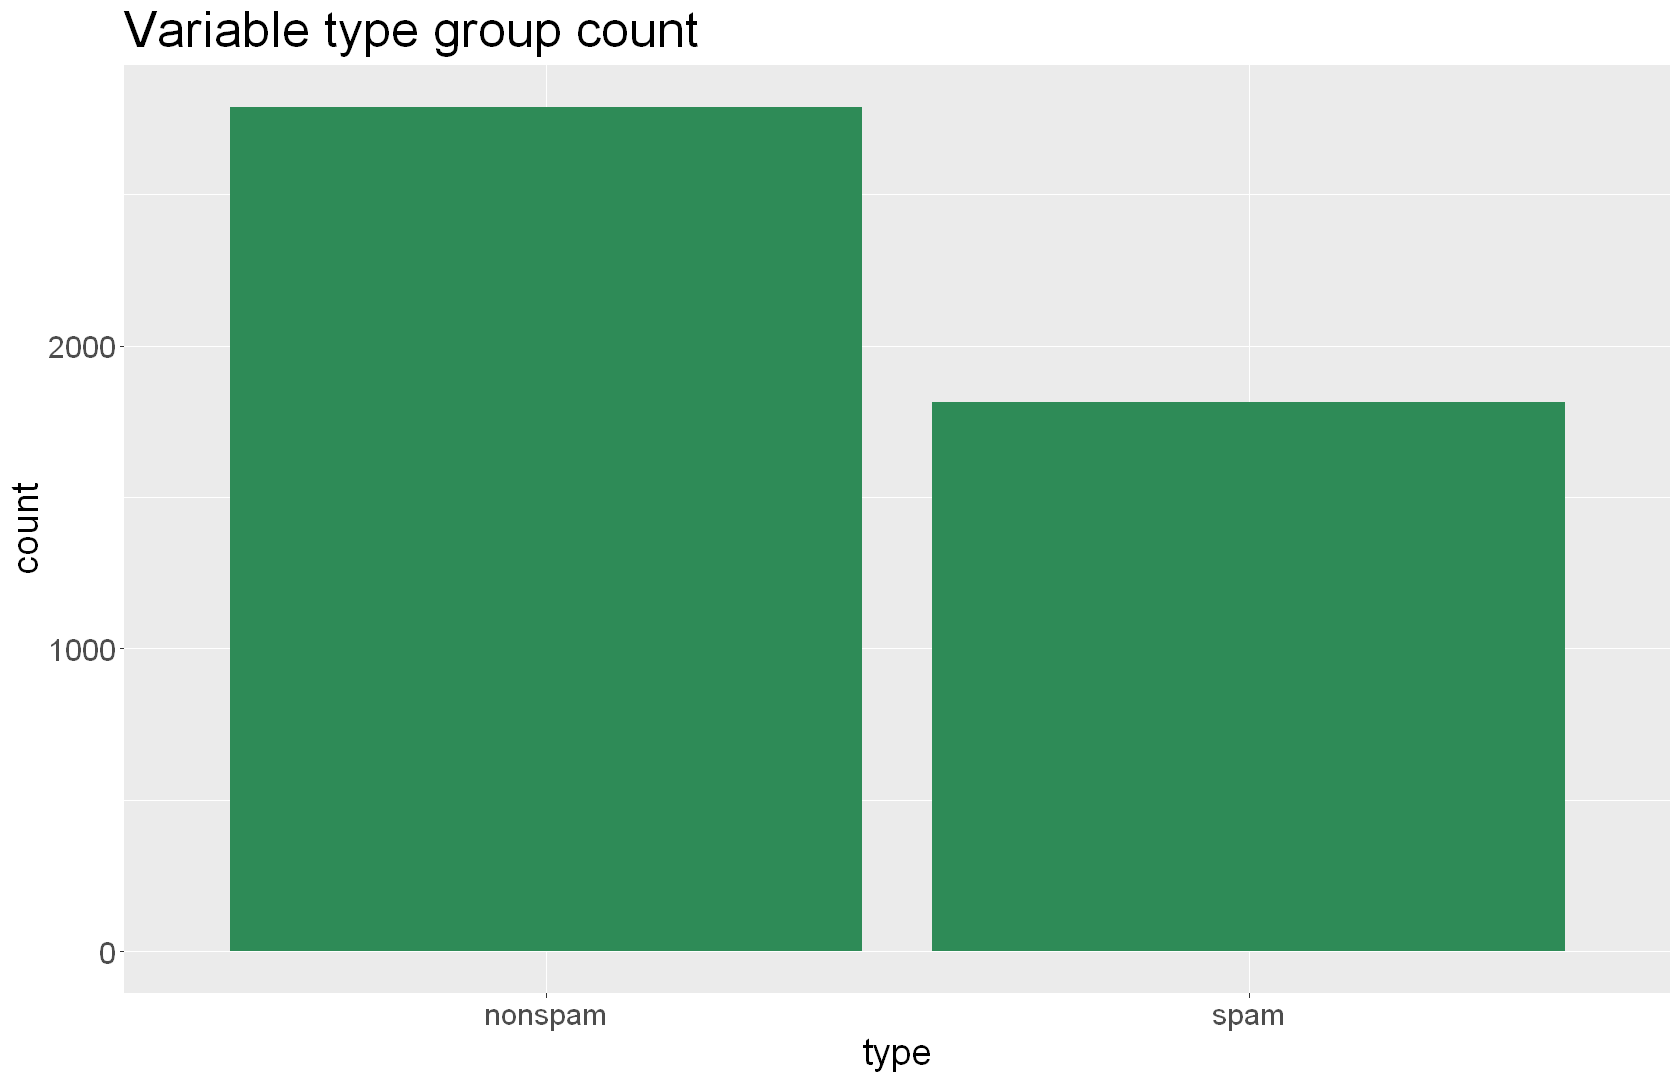

In [7]:
options(repr.plot.width = 14, repr.plot.height = 9)
ggplot(spam, aes(x=type)) +
    geom_bar(fill='seagreen4') +
    ggtitle('Variable type group count') +
    theme(
        plot.title = element_text(size = 30),
        axis.title = element_text(size = 22),         
        axis.text.x = element_text(size = 18),        
        axis.text.y = element_text(size = 18)
        )

In [32]:
findCorrelation(cor(spam[1:57]), cutoff=0.8)

[1] 32 34

In [3]:
spam <- spam[, -c(32, 34)]

# Data transformations

In [4]:
numeric_columns <- spam[, 1:55]
log_data <- as.data.frame(log(numeric_columns+0.1))
spam_log <- cbind(log_data, spam[, 56, drop = FALSE])
scaled_data <- as.data.frame(scale(numeric_columns))
spam_scaled <- cbind(scaled_data, spam[, 56, drop = FALSE])

# Classification error plots for KNN and Random forest

#### KNN

In [7]:
ks <- seq(1, 10)
avg_errs <- seq(1, 10)

for (i in 1:10) {
    errs <- seq(1, 100)
    for (j in 1:100) {
        train_ind <- createDataPartition(spam_scaled$type, p=0.75, list=FALSE)
        trn <- spam_scaled[train_ind,]
        tst  <- spam_scaled[-train_ind,]
        knn_grid <- data.frame(k=c(ks[i]))
        knn <- caret::train(type ~ ., data=trn, method='knn', tuneGrid=knn_grid)
        knn_pred <- predict(knn, newdata=tst)
        knn_cm <- confusionMatrix(tst$type, knn_pred)
        errs[j] <- 1 - as.numeric(knn_cm$overall['Accuracy'])
    }
    avg_errs[i] <- mean(errs)
}

In [8]:
ks <- seq(1, 10)
avg_errs1 <- seq(1, 10)

for (i in 1:10) {
    errs <- seq(1, 100)
    for (j in 1:100) {
        train_ind <- createDataPartition(spam_log$type, p=0.75, list=FALSE)
        trn <- spam_log[train_ind,]
        tst  <- spam_log[-train_ind,]
        knn_grid <- data.frame(k=c(ks[i]))
        knn <- caret::train(type ~ ., data=trn, method='knn', tuneGrid=knn_grid)
        knn_pred <- predict(knn, newdata=tst)
        knn_cm <- confusionMatrix(tst$type, knn_pred)
        errs[j] <- 1 - as.numeric(knn_cm$overall['Accuracy'])
    }
    avg_errs1[i] <- mean(errs)
}

In [9]:
knn_errs <- data.frame(
  x = rep(1:10, times = 2),
  y = c(avg_errs, avg_errs1),
  group = rep(c('zscore transformation', 'log(x+0.1) transformation'), each = 10)
)

write.csv(knn_errs, 'knn_errs.csv', row.names=FALSE)

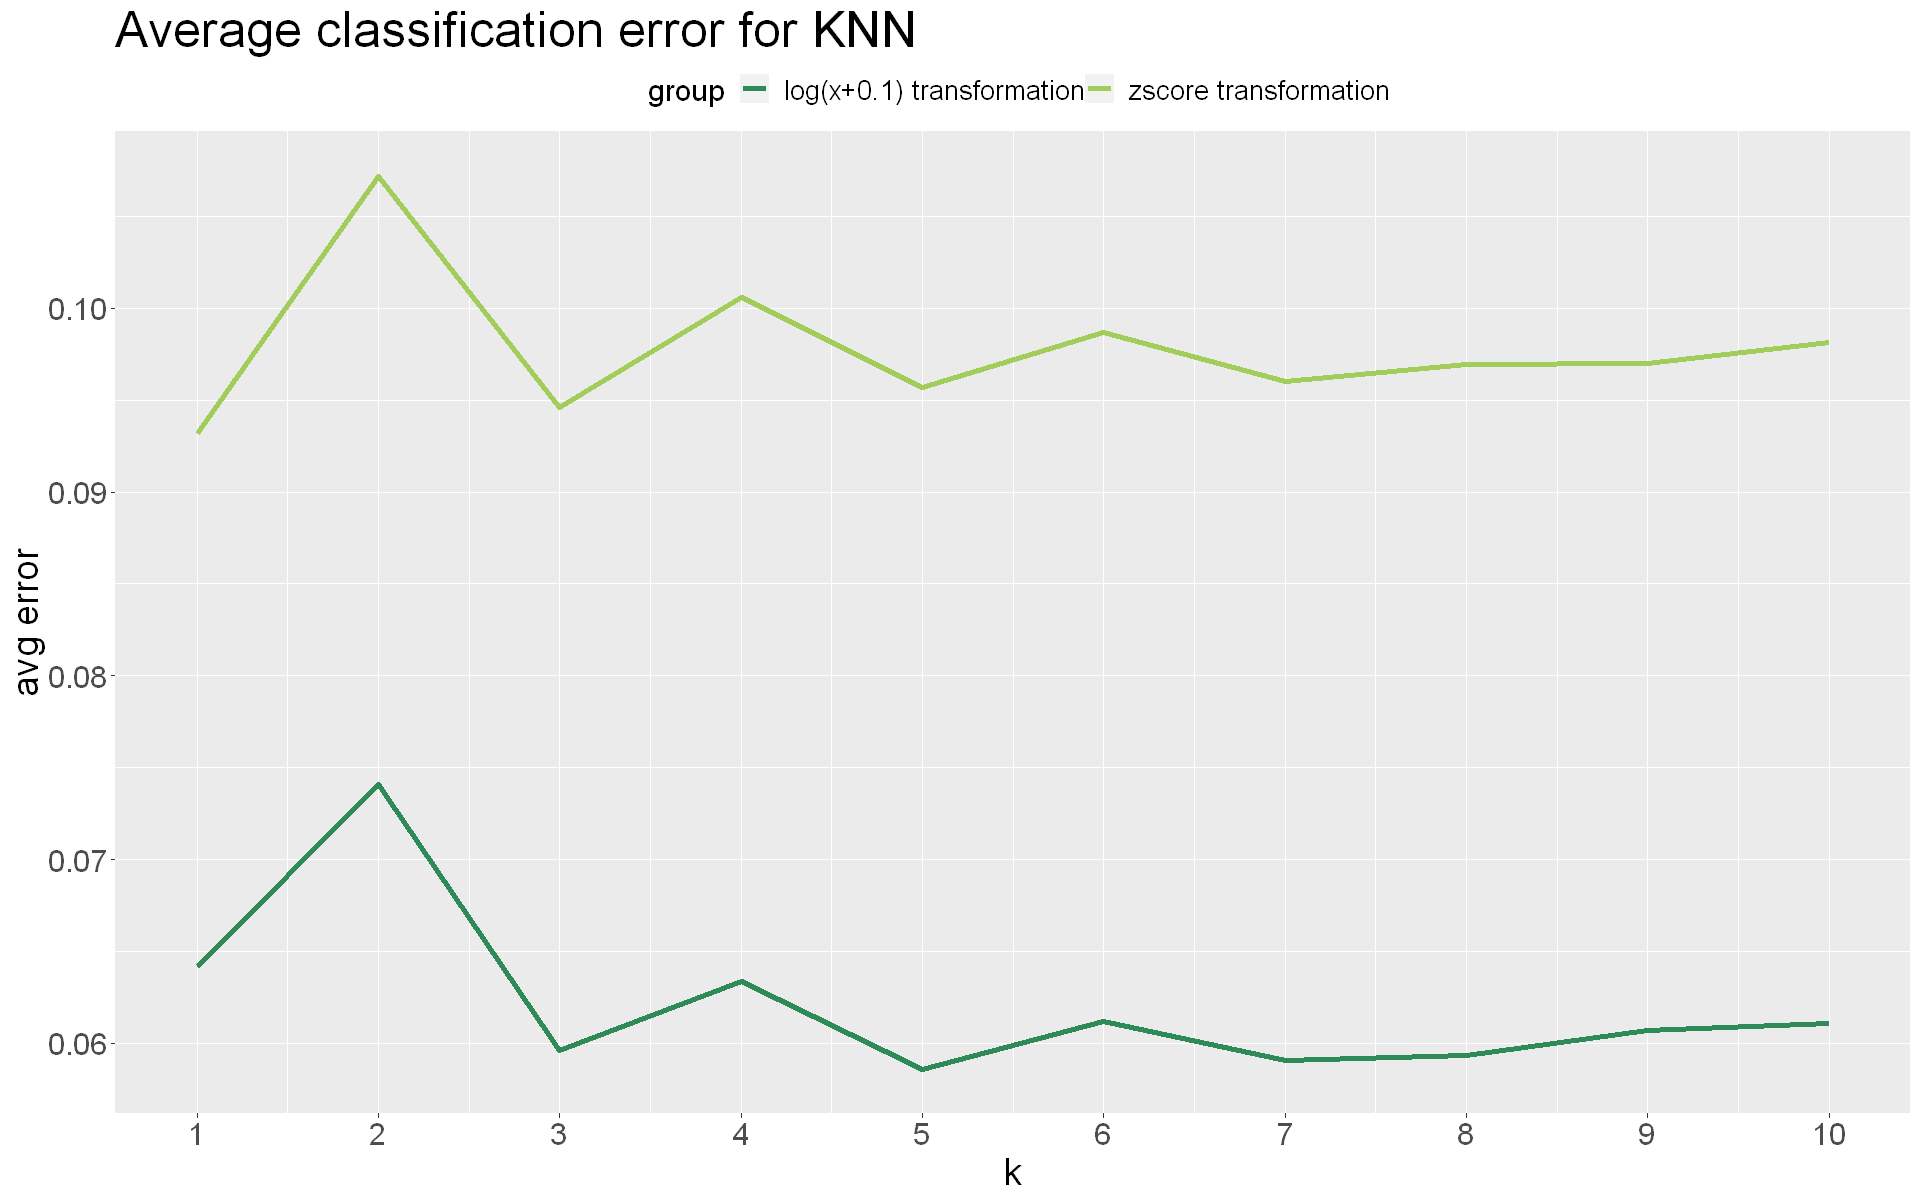

In [12]:
knn_errs <- read.csv('knn_errs.csv')

options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(knn_errs, aes(x = x, y = y, color = group)) +
  geom_line(linewidth=1.5)  + 
  labs(x = 'k', y = 'avg error', title = 'Average classification error for KNN') +
  scale_x_continuous(breaks=seq(1, 10, by = 1)) +
  scale_color_manual(values=c('seagreen4', 'darkolivegreen3')) +
  theme(
      plot.title = element_text(size = 30),
      axis.title = element_text(size = 22),         
      axis.text.x = element_text(size = 18),        
      axis.text.y = element_text(size = 18),
      legend.text = element_text(size = 16),        
      legend.title = element_text(size = 18),
      legend.position = 'top')

#### Random forest

In [106]:
mtrys <- seq(1, 55, by=5)
n <- length(mtrys)
avg_errs2 <- seq(1, n)

for (i in 1:n) {
    errs <- seq(1, 100)
    for (j in 1:100) {
        train_ind <- createDataPartition(spam_scaled$type, p=0.75, list=FALSE)
        trn <- spam_scaled[train_ind,]
        tst  <- spam_scaled[-train_ind,]
        rf_grid <- data.frame(mtry=c(mtrys[i]))
        rf <- caret::train(type ~ ., data=trn, method='rf', tuneGrid=rf_grid, ntree=100)
        rf_pred <- predict(rf, newdata=tst)
        rf_cm <- confusionMatrix(tst$type, rf_pred)
        errs[j] <- 1 - as.numeric(rf_cm$overall['Accuracy'])
    }
    avg_errs2[i] <- mean(errs)
}

In [107]:
mtrys <- seq(1, 55, by=5)
n <- length(mtrys)
avg_errs3 <- seq(1, n)

for (i in 1:n) {
    errs <- seq(1, 100)
    for (j in 1:100) {
        train_ind <- createDataPartition(spam_log$type, p=0.75, list=FALSE)
        trn <- spam_log[train_ind,]
        tst  <- spam_log[-train_ind,]
        rf_grid <- data.frame(mtry=c(mtrys[i]))
        rf <- caret::train(type ~ ., data=trn, method='rf', tuneGrid=rf_grid, ntree=100)
        rf_pred <- predict(rf, newdata=tst)
        rf_cm <- confusionMatrix(tst$type, rf_pred)
        errs[j] <- 1 - as.numeric(rf_cm$overall['Accuracy'])
    }
    avg_errs3[i] <- mean(errs)
}

In [108]:
rf_errs <- data.frame(
  x = rep(seq(1, 55, by=5), times=2),
  y = c(avg_errs2, avg_errs3),
  group = rep(c('zscore transformation', 'log(x+0.1) transformation'), each = n)
)

write.csv(rf_errs, 'rf_errs.csv', row.names=FALSE)

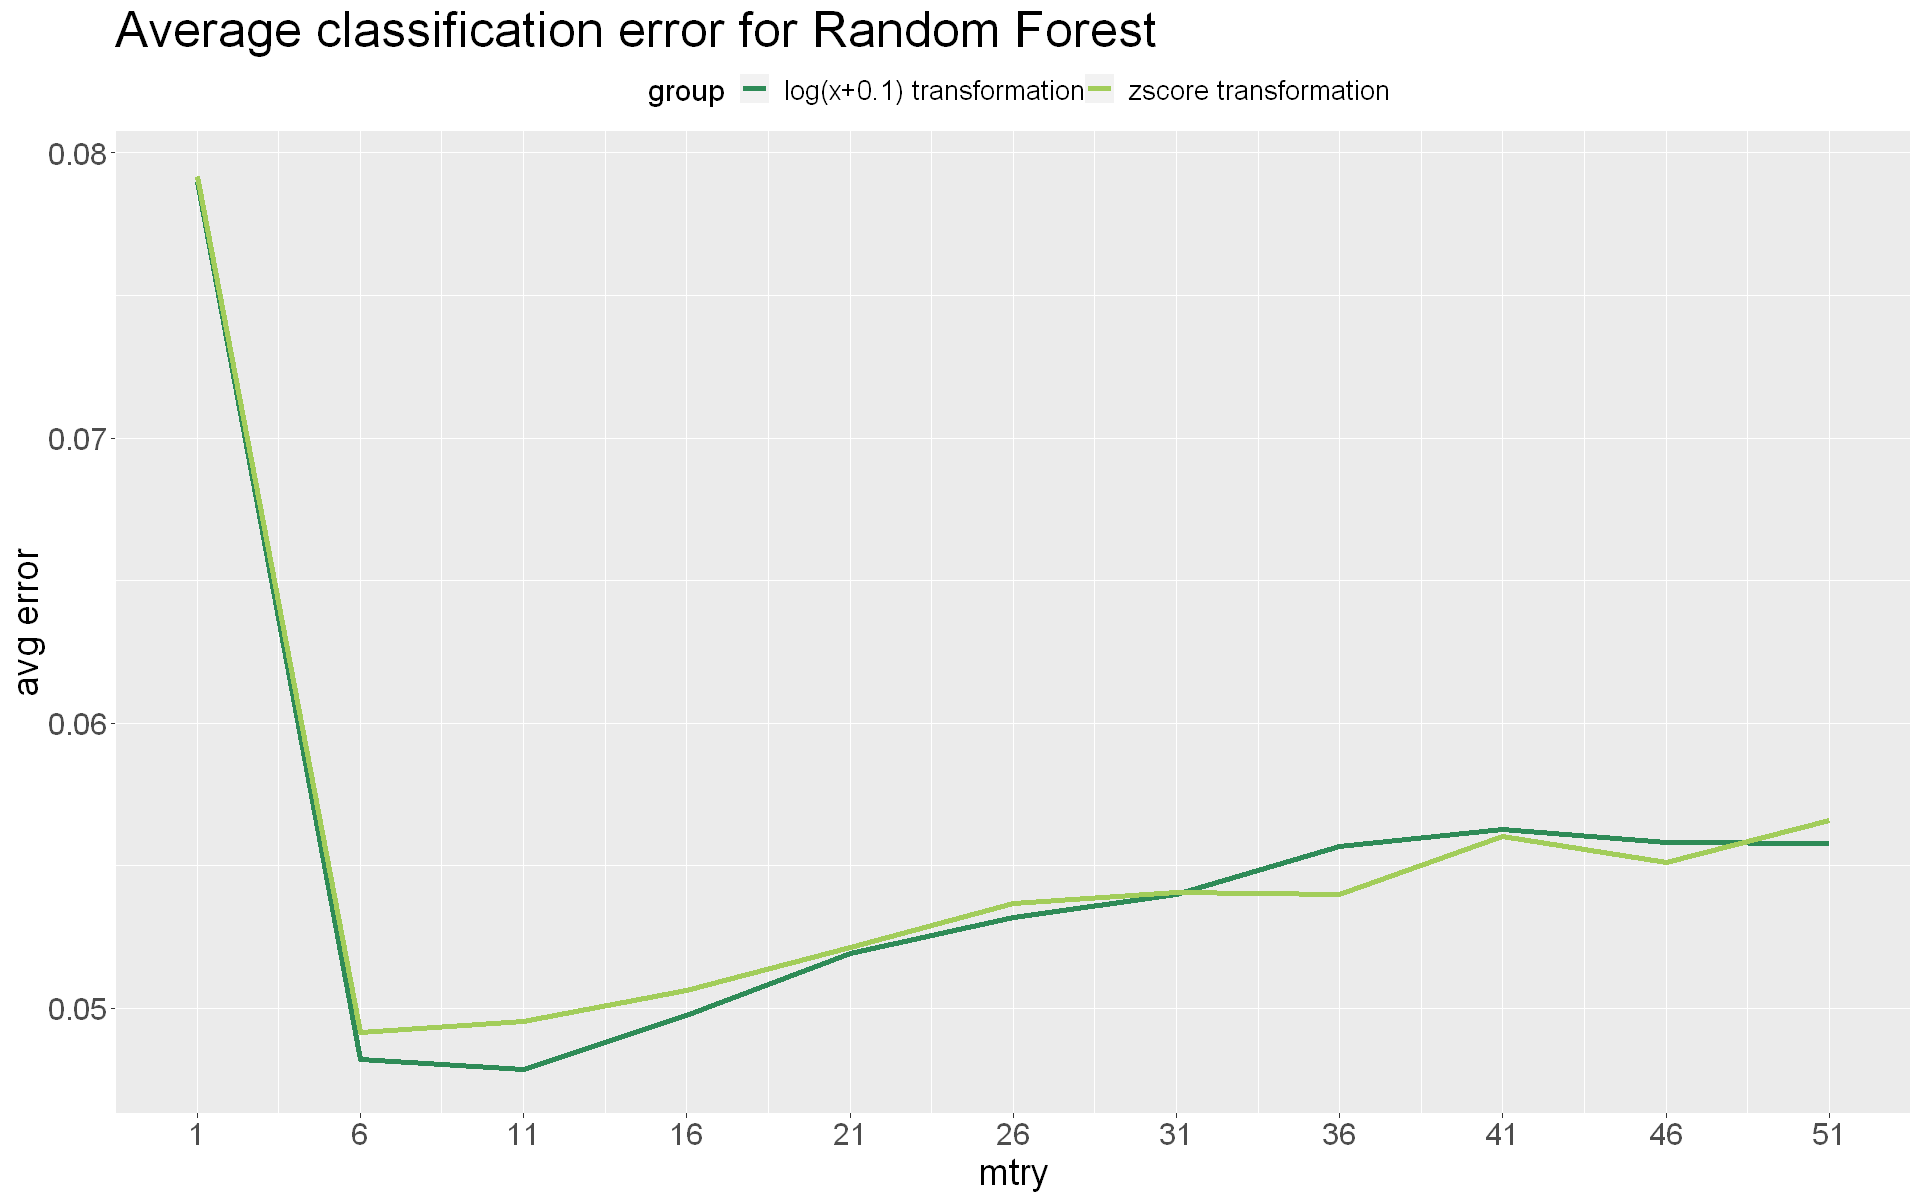

In [11]:
rf_errs <- read.csv('rf_errs.csv')

options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(rf_errs, aes(x = x, y = y, color = group)) +
  geom_line(linewidth=1.5)  + 
  labs(x = 'mtry', y = 'avg error', title = 'Average classification error for Random Forest') +
  scale_x_continuous(breaks=seq(1, 55, by=5)) +
  scale_color_manual(values=c('seagreen4', 'darkolivegreen3')) +
  theme(
      plot.title = element_text(size = 30),
      axis.title = element_text(size = 22),         
      axis.text.x = element_text(size = 18),        
      axis.text.y = element_text(size = 18),
      legend.text = element_text(size = 16),        
      legend.title = element_text(size = 18),
      legend.position = 'top')

# Evaluation of the models

In [6]:
train_indices <- createDataPartition(spam_scaled$type, p = 0.75, list = FALSE)

### All features

In [109]:
train <- spam_log[train_indices,]
test  <- spam_log[-train_indices,]

In [67]:
train_scaled <- spam_scaled[train_indices,]
test_scaled <- spam_scaled[-train_indices,]

KNN

In [27]:
knn_grid <- data.frame(k=seq(1, 10, by=1))
knn_control <- trainControl(method='cv', number=5)
knn <- caret::train(type ~ ., data=train, method='knn', trControl=knn_control, tuneGrid=knn_grid)
knn$bestTune

,k
,<dbl>
3,3


In [28]:
knn_pred <- predict(knn, newdata=test)
knn_cm <- confusionMatrix(test$type, knn_pred, positive = "spam")
knn_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     665   32
   spam         38  415
                                          
               Accuracy : 0.9391          
                 95% CI : (0.9237, 0.9522)
    No Information Rate : 0.6113          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8722          
                                          
 Mcnemar's Test P-Value : 0.5501          
                                          
            Sensitivity : 0.9284          
            Specificity : 0.9459          
         Pos Pred Value : 0.9161          
         Neg Pred Value : 0.9541          
             Prevalence : 0.3887          
         Detection Rate : 0.3609          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9372          
                                          
       'Positive' Class : spam            
               

Random forest

In [64]:
rf_grid <- expand.grid(mtry=seq(1, 51, by=5))
rf_control <- trainControl(method='cv', number=5)
rf <- caret::train(type ~ ., data=train, method='rf', trControl=rf_control, tuneGrid=rf_grid, ntree=100)
rf$bestTune

,mtry
,<dbl>
2,6


In [65]:
rf_pred <- predict(rf, newdata=test)
rf_cm <- confusionMatrix(test$type, rf_pred, positive = "spam")
rf_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     677   20
   spam         41  412
                                          
               Accuracy : 0.947           
                 95% CI : (0.9324, 0.9592)
    No Information Rate : 0.6243          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.888           
                                          
 Mcnemar's Test P-Value : 0.01045         
                                          
            Sensitivity : 0.9537          
            Specificity : 0.9429          
         Pos Pred Value : 0.9095          
         Neg Pred Value : 0.9713          
             Prevalence : 0.3757          
         Detection Rate : 0.3583          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9483          
                                          
       'Positive' Class : spam            
               

LDA and QDA (first for z-scaled data and then for log-transformed data)

In [68]:
lda_fit <- lda(type ~ ., data = train_scaled)
lda_predictions <- predict(lda_fit, test_scaled)
qda_fit <- qda(type ~ ., data = train_scaled)
qda_predictions <- predict(qda_fit, test_scaled)

In [69]:
lda_cm <- confusionMatrix(test$type, lda_predictions$class, positive = "spam")
qda_cm <- confusionMatrix(test$type, qda_predictions$class, positive = "spam")

In [70]:
lda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     661   36
   spam         90  363
                                          
               Accuracy : 0.8904          
                 95% CI : (0.8709, 0.9079)
    No Information Rate : 0.653           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7657          
                                          
 Mcnemar's Test P-Value : 2.34e-06        
                                          
            Sensitivity : 0.9098          
            Specificity : 0.8802          
         Pos Pred Value : 0.8013          
         Neg Pred Value : 0.9484          
             Prevalence : 0.3470          
         Detection Rate : 0.3157          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8950          
                                          
       'Positive' Class : spam            
               

In [71]:
qda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     539  158
   spam         18  435
                                          
               Accuracy : 0.847           
                 95% CI : (0.8248, 0.8673)
    No Information Rate : 0.5157          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6959          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7336          
            Specificity : 0.9677          
         Pos Pred Value : 0.9603          
         Neg Pred Value : 0.7733          
             Prevalence : 0.5157          
         Detection Rate : 0.3783          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8506          
                                          
       'Positive' Class : spam            
               

In [113]:
lda_fit <- lda(type ~ ., data = train)
lda_predictions <- predict(lda_fit, test)
qda_fit <- qda(type ~ ., data = train)
qda_predictions <- predict(qda_fit, test)

In [114]:
lda_cm <- confusionMatrix(test$type, lda_predictions$class, positive = "spam")
qda_cm <- confusionMatrix(test$type, qda_predictions$class, positive = "spam")

In [115]:
lda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     675   22
   spam         53  400
                                          
               Accuracy : 0.9348          
                 95% CI : (0.9189, 0.9484)
    No Information Rate : 0.633           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8618          
                                          
 Mcnemar's Test P-Value : 0.000532        
                                          
            Sensitivity : 0.9479          
            Specificity : 0.9272          
         Pos Pred Value : 0.8830          
         Neg Pred Value : 0.9684          
             Prevalence : 0.3670          
         Detection Rate : 0.3478          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9375          
                                          
       'Positive' Class : spam            
               

In [116]:
qda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     558  139
   spam         25  428
                                          
               Accuracy : 0.8574          
                 95% CI : (0.8358, 0.8771)
    No Information Rate : 0.507           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7139          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7549          
            Specificity : 0.9571          
         Pos Pred Value : 0.9448          
         Neg Pred Value : 0.8006          
             Prevalence : 0.4930          
         Detection Rate : 0.3722          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8560          
                                          
       'Positive' Class : spam            
               

### Frequency only

In [75]:
spam_freq <- spam_log[, -c(53, 54, 55)]

In [76]:
train <- spam_freq[train_indices,]
test <- spam_freq[-train_indices,]

KNN

In [8]:
knn_grid <- data.frame(k=seq(1, 10, by=1))
knn_control <- trainControl(method='cv', number=5)
knn <- caret::train(type ~ ., data=train, method='knn', trControl=knn_control, tuneGrid=knn_grid)
knn$bestTune    

,k
,<dbl>
3,3


In [9]:
knn_pred <- predict(knn, newdata=test)
knn_cm <- confusionMatrix(test$type, knn_pred, positive="spam")
knn_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     662   35
   spam         47  406
                                          
               Accuracy : 0.9287          
                 95% CI : (0.9123, 0.9429)
    No Information Rate : 0.6165          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.85            
                                          
 Mcnemar's Test P-Value : 0.2245          
                                          
            Sensitivity : 0.9206          
            Specificity : 0.9337          
         Pos Pred Value : 0.8962          
         Neg Pred Value : 0.9498          
             Prevalence : 0.3835          
         Detection Rate : 0.3530          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9272          
                                          
       'Positive' Class : spam            
               

Random forest

In [77]:
rf_grid <- expand.grid(mtry=seq(1, 55, by=5))
rf_control <- trainControl(method='cv', number=5)
rf <- caret::train(type ~ ., data=train, method='rf', trControl=rf_control, tuneGrid=rf_grid, ntree=100)
rf$bestTune

,mtry
,<dbl>
2,6


In [79]:
rf_pred <- predict(rf, newdata=test)
rf_cm <- confusionMatrix(test$type, rf_pred, positive="spam")
rf_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     676   21
   spam         37  416
                                          
               Accuracy : 0.9496          
                 95% CI : (0.9353, 0.9615)
    No Information Rate : 0.62            
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.8937          
                                          
 Mcnemar's Test P-Value : 0.04888         
                                          
            Sensitivity : 0.9519          
            Specificity : 0.9481          
         Pos Pred Value : 0.9183          
         Neg Pred Value : 0.9699          
             Prevalence : 0.3800          
         Detection Rate : 0.3617          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9500          
                                          
       'Positive' Class : spam            
               

LDA and QDA

In [80]:
lda_fit <- lda(type ~ ., data = train)
lda_predictions <- predict(lda_fit, test)
qda_fit <- qda(type ~ ., data = train)
qda_predictions <- predict(qda_fit, test)

In [81]:
lda_cm <- confusionMatrix(test$type, lda_predictions$class, positive = "spam")
qda_cm <- confusionMatrix(test$type, qda_predictions$class, positive = "spam")

In [82]:
lda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     670   27
   spam         56  397
                                          
               Accuracy : 0.9278          
                 95% CI : (0.9113, 0.9421)
    No Information Rate : 0.6313          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8471          
                                          
 Mcnemar's Test P-Value : 0.002116        
                                          
            Sensitivity : 0.9363          
            Specificity : 0.9229          
         Pos Pred Value : 0.8764          
         Neg Pred Value : 0.9613          
             Prevalence : 0.3687          
         Detection Rate : 0.3452          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9296          
                                          
       'Positive' Class : spam            
               

In [83]:
qda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     552  145
   spam         24  429
                                         
               Accuracy : 0.853          
                 95% CI : (0.8312, 0.873)
    No Information Rate : 0.5009         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.706          
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.7474         
            Specificity : 0.9583         
         Pos Pred Value : 0.9470         
         Neg Pred Value : 0.7920         
             Prevalence : 0.4991         
         Detection Rate : 0.3730         
   Detection Prevalence : 0.3939         
      Balanced Accuracy : 0.8529         
                                         
       'Positive' Class : spam           
                                   

### Capital only

In [84]:
spam_capital <- spam_log[, 53:56]

In [85]:
train <- spam_capital[train_indices,]
test  <- spam_capital[-train_indices,]

KNN

In [17]:
knn_grid <- data.frame(k=seq(1, 10, by=1))
knn_control <- trainControl(method='cv', number=5)
knn <- caret::train(type ~ ., data=train, method='knn', trControl=knn_control, tuneGrid=knn_grid)
knn$bestTune    

,k
,<dbl>
1,1


In [18]:
knn_pred <- predict(knn, newdata=test)
knn_cm <- confusionMatrix(test$type, knn_pred, positive="spam")
knn_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     578  119
   spam        112  341
                                          
               Accuracy : 0.7991          
                 95% CI : (0.7748, 0.8219)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5805          
                                          
 Mcnemar's Test P-Value : 0.693           
                                          
            Sensitivity : 0.7413          
            Specificity : 0.8377          
         Pos Pred Value : 0.7528          
         Neg Pred Value : 0.8293          
             Prevalence : 0.4000          
         Detection Rate : 0.2965          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.7895          
                                          
       'Positive' Class : spam            
               

Random forest

In [86]:
rf_grid <- expand.grid(mtry=1:3)
rf_control <- trainControl(method='cv', number=5)
rf <- caret::train(type ~ ., data=train, method='rf', trControl=rf_control, tuneGrid=rf_grid, ntree=100)
rf$bestTune

,mtry
,<int>
1,1


In [87]:
rf_pred <- predict(rf, newdata=test)
rf_cm <- confusionMatrix(test$type, rf_pred, positive="spam")
rf_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     619   78
   spam        120  333
                                          
               Accuracy : 0.8278          
                 95% CI : (0.8047, 0.8492)
    No Information Rate : 0.6426          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6335          
                                          
 Mcnemar's Test P-Value : 0.003571        
                                          
            Sensitivity : 0.8102          
            Specificity : 0.8376          
         Pos Pred Value : 0.7351          
         Neg Pred Value : 0.8881          
             Prevalence : 0.3574          
         Detection Rate : 0.2896          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8239          
                                          
       'Positive' Class : spam            
               

LDA and QDA

In [88]:
lda_fit <- lda(type ~ ., data = train)
lda_predictions <- predict(lda_fit, test)
qda_fit <- qda(type ~ ., data = train)
qda_predictions <- predict(qda_fit, test)

In [89]:
lda_cm <- confusionMatrix(test$type, lda_predictions$class, positive = "spam")
qda_cm <- confusionMatrix(test$type, qda_predictions$class, positive = "spam")

In [90]:
lda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     595  102
   spam        208  245
                                          
               Accuracy : 0.7304          
                 95% CI : (0.7038, 0.7559)
    No Information Rate : 0.6983          
    P-Value [Acc > NIR] : 0.009007        
                                          
                  Kappa : 0.4113          
                                          
 Mcnemar's Test P-Value : 2.467e-09       
                                          
            Sensitivity : 0.7061          
            Specificity : 0.7410          
         Pos Pred Value : 0.5408          
         Neg Pred Value : 0.8537          
             Prevalence : 0.3017          
         Detection Rate : 0.2130          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.7235          
                                          
       'Positive' Class : spam            
               

In [91]:
qda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     619   78
   spam        247  206
                                          
               Accuracy : 0.7174          
                 95% CI : (0.6904, 0.7433)
    No Information Rate : 0.753           
    P-Value [Acc > NIR] : 0.9974          
                                          
                  Kappa : 0.3668          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7254          
            Specificity : 0.7148          
         Pos Pred Value : 0.4547          
         Neg Pred Value : 0.8881          
             Prevalence : 0.2470          
         Detection Rate : 0.1791          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.7201          
                                          
       'Positive' Class : spam            
               

### Biggest diffs

In [92]:
spam_diffs <- spam_log[, c('george', 'you', 'your', 'hp', 'free', 'hpl', 'charExclamation', 'our', 're', 'edu', 'type')]

In [93]:
train <- spam_diffs[train_indices,]
test  <- spam_diffs[-train_indices,]

KNN

In [21]:
knn_grid <- data.frame(k=seq(1, 10, by=1))
knn_control <- trainControl(method='cv', number=5)
knn <- caret::train(type ~ ., data=train, method='knn', trControl=knn_control, tuneGrid=knn_grid)
knn$bestTune    

,k
,<dbl>
10,10


In [23]:
knn_pred <- predict(knn, newdata=test)
knn_cm <- confusionMatrix(test$type, knn_pred, positive="spam")
knn_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     644   53
   spam         62  391
                                          
               Accuracy : 0.9             
                 95% CI : (0.8812, 0.9167)
    No Information Rate : 0.6139          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7898          
                                          
 Mcnemar's Test P-Value : 0.4557          
                                          
            Sensitivity : 0.8806          
            Specificity : 0.9122          
         Pos Pred Value : 0.8631          
         Neg Pred Value : 0.9240          
             Prevalence : 0.3861          
         Detection Rate : 0.3400          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8964          
                                          
       'Positive' Class : spam            
               

Random forest

In [94]:
rf_grid <- expand.grid(mtry=1:10)
rf_control <- trainControl(method='cv', number=5)
rf <- caret::train(type ~ ., data=train, method='rf', trControl=rf_control, tuneGrid=rf_grid, ntree=100)
rf$bestTune

,mtry
,<int>
5,5


In [95]:
rf_pred <- predict(rf, newdata=test)
rf_cm <- confusionMatrix(test$type, rf_pred, positive="spam")
rf_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     664   33
   spam         61  392
                                          
               Accuracy : 0.9183          
                 95% CI : (0.9009, 0.9334)
    No Information Rate : 0.6304          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8269          
                                          
 Mcnemar's Test P-Value : 0.005355        
                                          
            Sensitivity : 0.9224          
            Specificity : 0.9159          
         Pos Pred Value : 0.8653          
         Neg Pred Value : 0.9527          
             Prevalence : 0.3696          
         Detection Rate : 0.3409          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9191          
                                          
       'Positive' Class : spam            
               

In [96]:
lda_fit <- lda(type ~ ., data = train)
lda_predictions <- predict(lda_fit, test)
qda_fit <- qda(type ~ ., data = train)
qda_predictions <- predict(qda_fit, test)

In [97]:
lda_cm <- confusionMatrix(test$type, lda_predictions$class, positive = "spam")
qda_cm <- confusionMatrix(test$type, qda_predictions$class, positive = "spam")

In [98]:
lda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     644   53
   spam         75  378
                                          
               Accuracy : 0.8887          
                 95% CI : (0.8691, 0.9063)
    No Information Rate : 0.6252          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.7649          
                                          
 Mcnemar's Test P-Value : 0.06343         
                                          
            Sensitivity : 0.8770          
            Specificity : 0.8957          
         Pos Pred Value : 0.8344          
         Neg Pred Value : 0.9240          
             Prevalence : 0.3748          
         Detection Rate : 0.3287          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8864          
                                          
       'Positive' Class : spam            
               

In [99]:
qda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     478  219
   spam         19  434
                                          
               Accuracy : 0.793           
                 95% CI : (0.7685, 0.8161)
    No Information Rate : 0.5678          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5977          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6646          
            Specificity : 0.9618          
         Pos Pred Value : 0.9581          
         Neg Pred Value : 0.6858          
             Prevalence : 0.5678          
         Detection Rate : 0.3774          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8132          
                                          
       'Positive' Class : spam            
               

### Most correlated with type

In [117]:
spam_cor <- spam[, c('your', 'num000', 'remove', 'charDollar', 'you', 'free', 'business', 'hp', 'capitalTotal', 'our', 'type')]

In [118]:
train <- spam_cor[train_indices,]
test  <- spam_cor[-train_indices,]

KNN

In [26]:
knn_grid <- data.frame(k=seq(1, 10, by=1))
knn_control <- trainControl(method='cv', number=5)
knn <- caret::train(type ~ ., data=train, method='knn', trControl=knn_control, tuneGrid=knn_grid)
knn$bestTune    

,k
,<dbl>
1,1


In [27]:
knn_pred <- predict(knn, newdata=test)
knn_cm <- confusionMatrix(test$type, knn_pred, positive="spam")
knn_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     592  105
   spam        117  336
                                          
               Accuracy : 0.807           
                 95% CI : (0.7829, 0.8294)
    No Information Rate : 0.6165          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5938          
                                          
 Mcnemar's Test P-Value : 0.4603          
                                          
            Sensitivity : 0.7619          
            Specificity : 0.8350          
         Pos Pred Value : 0.7417          
         Neg Pred Value : 0.8494          
             Prevalence : 0.3835          
         Detection Rate : 0.2922          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.7984          
                                          
       'Positive' Class : spam            
               

Random forest

In [102]:
rf_grid <- expand.grid(mtry=1:10)
rf_control <- trainControl(method='cv', number=5)
rf <- caret::train(type ~ ., data=train, method='rf', trControl=rf_control, tuneGrid=rf_grid, ntree=100)
rf$bestTune

,mtry
,<int>
3,3


In [104]:
rf_pred <- predict(rf, newdata=test)
rf_cm <- confusionMatrix(test$type, rf_pred, positive="spam")
rf_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     661   36
   spam         45  408
                                          
               Accuracy : 0.9296          
                 95% CI : (0.9132, 0.9437)
    No Information Rate : 0.6139          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.852           
                                          
 Mcnemar's Test P-Value : 0.3741          
                                          
            Sensitivity : 0.9189          
            Specificity : 0.9363          
         Pos Pred Value : 0.9007          
         Neg Pred Value : 0.9484          
             Prevalence : 0.3861          
         Detection Rate : 0.3548          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.9276          
                                          
       'Positive' Class : spam            
               

In [123]:
lda_fit <- lda(type ~ ., data = train)
lda_predictions <- predict(lda_fit, test)
qda_fit <- qda(type ~ ., data = train)
qda_predictions <- predict(qda_fit, test)

In [124]:
lda_cm <- confusionMatrix(test$type, lda_predictions$class, positive = "spam")
qda_cm <- confusionMatrix(test$type, qda_predictions$class, positive = "spam")

In [125]:
lda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     655   42
   spam        143  310
                                          
               Accuracy : 0.8391          
                 95% CI : (0.8166, 0.8599)
    No Information Rate : 0.6939          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6494          
                                          
 Mcnemar's Test P-Value : 1.95e-13        
                                          
            Sensitivity : 0.8807          
            Specificity : 0.8208          
         Pos Pred Value : 0.6843          
         Neg Pred Value : 0.9397          
             Prevalence : 0.3061          
         Detection Rate : 0.2696          
   Detection Prevalence : 0.3939          
      Balanced Accuracy : 0.8507          
                                          
       'Positive' Class : spam            
               

In [126]:
qda_cm

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     653   44
   spam        125  328
                                         
               Accuracy : 0.853          
                 95% CI : (0.8312, 0.873)
    No Information Rate : 0.6765         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6823         
                                         
 Mcnemar's Test P-Value : 7.563e-10      
                                         
            Sensitivity : 0.8817         
            Specificity : 0.8393         
         Pos Pred Value : 0.7241         
         Neg Pred Value : 0.9369         
             Prevalence : 0.3235         
         Detection Rate : 0.2852         
   Detection Prevalence : 0.3939         
      Balanced Accuracy : 0.8605         
                                         
       'Positive' Class : spam           
                                   